In [1]:
import itertools
import gzip

import pandas as pd
import rdkit.Chem
import rdkit.Chem.AllChem
import rdkit.DataStructs
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem.AtomPairs import Torsions

from venn import venn
from venn import pseudovenn


In [3]:
# Download DrugBank SDF file of structures
! wget --timestamping --directory-prefix download https://go.drugbank.com/releases/5-1-9/downloads/all-open-structures -O drugbank_all_open_structures.sdf.zip
! unzip -d download download/drugbank_all_open_structures.sdf.zip
! rm download/drugbank_all_open_structures.sdf.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# Read SDF File
supplier = rdkit.Chem.SDMolSupplier('downloaded/all.sdf')
molecules = [mol for mol in supplier if mol is not None]
len(molecules)

11290

In [41]:
print(', '.join(dir(molecules[0])))
print(molecules[0].GetPropsAsDict())

AddConformer, ClearComputedProps, ClearProp, Compute2DCoords, ComputeGasteigerCharges, Debug, GetAromaticAtoms, GetAtomWithIdx, GetAtoms, GetAtomsMatchingQuery, GetBondBetweenAtoms, GetBondWithIdx, GetBonds, GetBoolProp, GetConformer, GetConformers, GetDoubleProp, GetIntProp, GetNumAtoms, GetNumBonds, GetNumConformers, GetNumHeavyAtoms, GetProp, GetPropNames, GetPropsAsDict, GetRingInfo, GetStereoGroups, GetSubstructMatch, GetSubstructMatches, GetUnsignedProp, HasProp, HasSubstructMatch, NeedsUpdatePropertyCache, RemoveAllConformers, RemoveConformer, SetBoolProp, SetDoubleProp, SetIntProp, SetProp, SetUnsignedProp, ToBinary, UpdatePropertyCache, __DebugMol, __GetSubstructMatch, __GetSubstructMatches, __class__, __copy__, __deepcopy__, __delattr__, __dict__, __dir__, __doc__, __eq__, __format__, __ge__, __getattribute__, __getinitargs__, __gt__, __hash__, __init__, __init_subclass__, __instance_size__, __le__, __lt__, __module__, __ne__, __new__, __reduce__, __reduce_ex__, __repr__, __s

In [122]:
# Calculate fingerprints of DrugBanks mols
fingerprints = list()
for mol in molecules:
    drugbank_id = mol.GetProp('DRUGBANK_ID')
    fingerprintMorgan = rdkit.Chem.AllChem.GetMorganFingerprint(mol, 2, useCounts=True, useFeatures=True)
    fingerprintMorganPure = rdkit.Chem.AllChem.GetMorganFingerprint(mol, 2)
    fingerprintMACCS = rdkit.Chem.AllChem.GetMACCSKeysFingerprint(mol)
    fingerprintRDK = rdkit.Chem.RDKFingerprint(mol)
    fingerprintAtomPair = Pairs.GetAtomPairFingerprintAsBitVect(mol)
    fingerprintTorsion = Torsions.GetTopologicalTorsionFingerprintAsIntVect(mol)
    
    fingerprints.append({
        'id': drugbank_id, 
        'fingerprintMACCS': fingerprintMACCS, 
        'fingerprintMorgan': fingerprintMorgan, 
        'fingerprintMorganPure': fingerprintMorganPure,
        'fingerprintRDK': fingerprintRDK,
        'fingerprintAtomPair': fingerprintAtomPair, 
        'fingerprintTorsion': fingerprintTorsion, 
    })

In [242]:
def culcSimilarity(primeSmile, fingerprints): 
  # Calculate pairwise compound similarities
  primeMol = rdkit.Chem.MolFromSmiles(primeSmile)
  primeFPMorgan = rdkit.Chem.AllChem.GetMorganFingerprint(primeMol, 2, useCounts=True, useFeatures=True)
  primeFPMorganPure = rdkit.Chem.AllChem.GetMorganFingerprint(primeMol, 2)
  primeFPMACCS = rdkit.Chem.AllChem.GetMACCSKeysFingerprint(primeMol)
  primeFPRDK = rdkit.Chem.RDKFingerprint(primeMol)
  primeFPAtomPair = Pairs.GetAtomPairFingerprintAsBitVect(primeMol)
  primeFPTorsion = Torsions.GetTopologicalTorsionFingerprintAsIntVect(primeMol)

  similarity_rows = list()
  for itemFPs in fingerprints:
    similarityMorganDice = round(rdkit.DataStructs.DiceSimilarity(itemFPs['fingerprintMorgan'], primeFPMorgan), 4)
    similarityMorganPureDice = round(rdkit.DataStructs.DiceSimilarity(itemFPs['fingerprintMorganPure'], primeFPMorganPure), 4)
    similarityMACCSDice = round(rdkit.DataStructs.DiceSimilarity(itemFPs['fingerprintMACCS'], primeFPMACCS), 4)
    similarityRDKDice = round(rdkit.DataStructs.DiceSimilarity(itemFPs['fingerprintRDK'], primeFPRDK), 4)
    similarityAtomPairDice = round(rdkit.DataStructs.DiceSimilarity(itemFPs['fingerprintAtomPair'], primeFPAtomPair), 4)
    similarityTorsionDice = round(rdkit.DataStructs.DiceSimilarity(itemFPs['fingerprintTorsion'], primeFPTorsion), 4)
   
    similarityMACCSTanimoto = round(rdkit.DataStructs.FingerprintSimilarity(itemFPs['fingerprintMACCS'], primeFPMACCS), 4)
    similarityRDKDiceTanimoto = round(rdkit.DataStructs.FingerprintSimilarity(itemFPs['fingerprintRDK'], primeFPRDK), 4)

    similarity_rows.append({
      'id': itemFPs['id'], 
      'similarityStruct.MACCS.Dice': similarityMACCSDice, 
      'similarityStruct.Morgan.Dice': similarityMorganDice,
      'similarityStruct.MorganPure.Dice': similarityMorganPureDice,
      'similarityStruct.RDK.Dice': similarityRDKDice,
      'similarityStruct.AtomPair.Dice': similarityAtomPairDice,
      'similarityStruct.Torsion.Dice': similarityTorsionDice,

      'similarityStruct.MACCS.Tanimoto': similarityMACCSTanimoto,
      'similarityStruct.RDK.Tanimoto': similarityRDKDiceTanimoto,
    })
  return similarity_rows

In [243]:
def findBest(primeSmile, fingerprints):
  similarity_rows = culcSimilarity(primeSmile, fingerprints)
  df = pd.DataFrame(similarity_rows)

  cols = df.columns.to_list()
  cols.remove('id')

  summary = dict()
  for col in cols:
    summary[col] = df.sort_values(by=[col], ignore_index=True, ascending=False)[0:1000]['id'].to_list()

  bestOfAll = set.intersection(*map(set,[x for x in summary.values()]))
  # print(bestOfAll)
  print('number of best', len(bestOfAll))

  return df[df['id'].isin(bestOfAll)].reset_index(drop=True)


In [216]:
# find Best
dfMols = pd.read_csv('molsForSimilarity.tsv', sep="\t")

dfAll = pd.DataFrame()
dfBest = pd.DataFrame()
for (i, row) in dfMols.iterrows(): 
  print(row['MineID'])
  resBest =  findBest(row['biochemical.smiles'], fingerprints)
  resBest['Source.MineID'] = row['MineID']
  resBest['Source.PubChemCID'] = row['PubChem CID']
  resBest['Source.DrugBankID'] = row['DrugBank ID']
  dfBest = pd.concat([dfBest, resBest], ignore_index=True, sort=False)

  resAll =  pd.DataFrame(culcSimilarity(row['biochemical.smiles'], fingerprints))
  resAll['Source.MineID'] = row['MineID']
  resAll['Source.PubChemCID'] = row['PubChem CID']
  resAll['Source.DrugBankID'] = row['DrugBank ID']
  dfAll = pd.concat([dfAll, resAll], ignore_index=True, sort=False)

1
number of best 10
2
number of best 44
5
number of best 100
6
number of best 102
7
number of best 37
8
number of best 35
9
number of best 85
10
number of best 109
11
number of best 13
12
number of best 238
13
number of best 67
14
number of best 285
15
number of best 399
16
number of best 121
17
number of best 13
19
number of best 24
20
number of best 31
21
number of best 22
22
number of best 399
23
number of best 211
24
number of best 63
25
number of best 42
26
number of best 42
27
number of best 42
28
number of best 234
29
number of best 233
30
number of best 238


In [219]:
len(dfAll), len(dfBest)


(304830, 3239)

In [222]:
dfAll.to_csv('./data/similarityAll.tsv', sep='\t')
dfBest.to_csv('./data/similarityBest.tsv', sep='\t')

In [295]:
def VennForBest(primeSmile, fingerprints):
  similarity_rows = culcSimilarity(primeSmile, fingerprints)
  df = pd.DataFrame(similarity_rows)

  cols = df.columns.to_list()
  cols.remove('id')

  summary = dict()
  for col in cols:
    summary[col] = set(df.sort_values(by=[col], ignore_index=True, ascending=False)[0:1000]['id'].to_list())
  
  
  summary = {str(key).replace('similarityStruct.', ''): summary[key] for key in summary}

  summarySlimRDK = {key: summary[key] for key in summary if key in [
    'RDK.Tanimoto',
    'RDK.Dice',
  ]}

  summarySlimMACCS = {key: summary[key] for key in summary if key in [
    'MACCS.Tanimoto',
    'MACCS.Dice'
  ]}

  summarySlimMorgan = {key: summary[key] for key in summary if key in [
    'MorganPure.Dice',
    'Morgan.Dice'
  ]}

  summarySlimFP = {key: summary[key] for key in summary if key in [
    'Torsion.Dice', 
    'AtomPair.Dice',
    'RDK.Dice',
    'Morgan.Dice',
    'MorganPure.Dice',
    'MACCS.Dice'
  ]}
  

  venn(summarySlimRDK)
  venn(summarySlimMACCS)
  venn(summarySlimFP, fontsize=8)
  venn(summarySlimMorgan)
  pseudovenn(summarySlimFP, cmap="hsv", legend_loc="upper right", hint_hidden=False, fontsize=10)

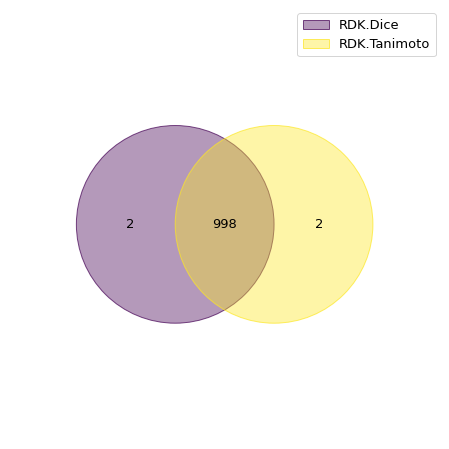

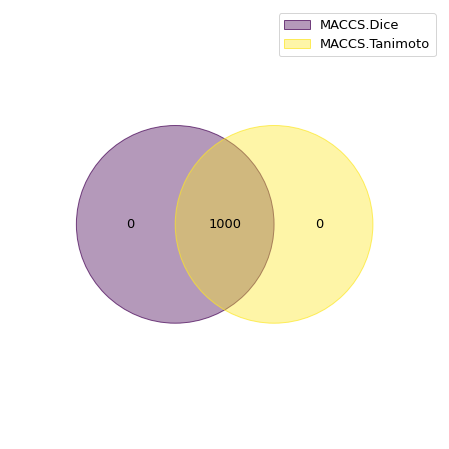

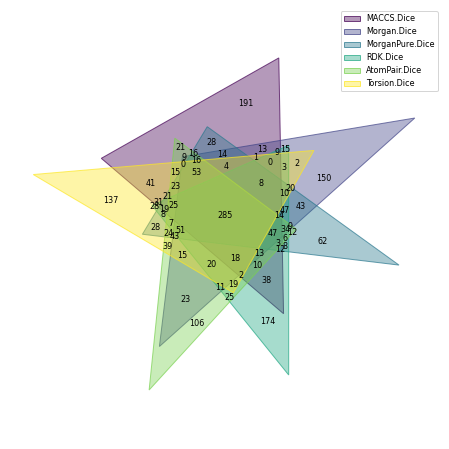

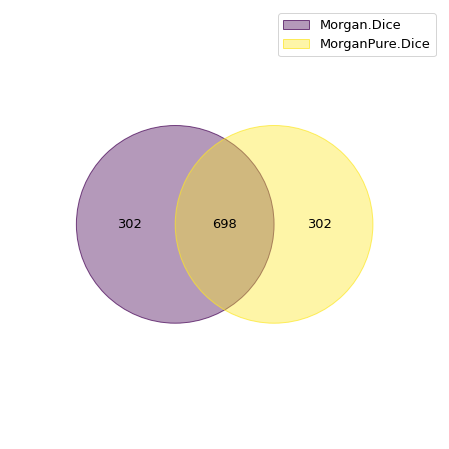

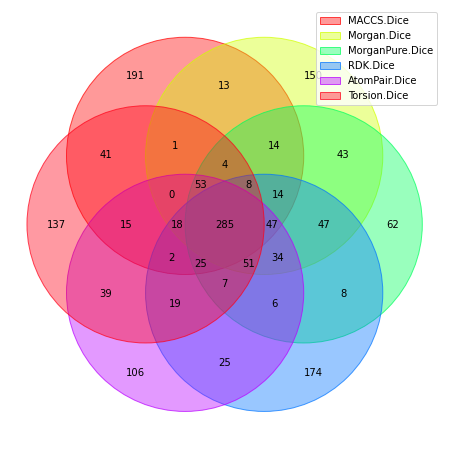

In [296]:
smile = "N[C@@H](CCCNC(N)=N)C(O)=O"
VennForBest(smile, fingerprints)

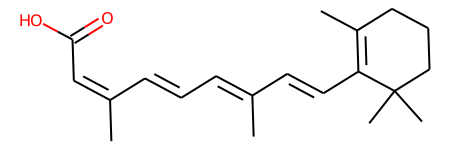

In [48]:
rdkit.Chem.MolFromSmiles(smile)

In [9]:
# Calculate pairwise compound similarities
similarity_rows = list()
for (id0, fp0), (id1, fp1) in itertools.combinations(fingerprints.items(), 2):
    similarity = rdkit.DataStructs.DiceSimilarity(fp0, fp1)
    similarity = round(similarity, 4)
    similarity_rows.append([id0, id1, similarity])

In [10]:
# Create a DataFrame of pairwise similarities
similarity_df = pd.DataFrame(similarity_rows, columns=['compound0', 'compound1', 'similarity'])
with gzip.open('data/similarity.tsv.gz', 'w') as write_file:
    similarity_df.to_csv(write_file, sep='\t', index=False)
similarity_df.head()

,compound0,compound1,similarity
0,DB00006,DB00007,0.5526
1,DB00006,DB00014,0.5178
2,DB00006,DB00027,0.4796
3,DB00006,DB00035,0.3911
4,DB00006,DB00050,0.5969


In [7]:
# Save a similarity tsv with only compounds in our slim drugbank set
drugbank_slim_df = pandas.read_table('data/drugbank-slim.tsv')
slim_ids = set(drugbank_slim_df.drugbank_id)
similarity_slim_df = similarity_df[similarity_df.compound0.isin(slim_ids) & similarity_df.compound1.isin(slim_ids)]
with gzip.open('data/similarity-slim.tsv.gz', 'w') as write_file:
    similarity_slim_df.to_csv(write_file, sep='\t', index=False)
float(len(similarity_slim_df)) / len(similarity_df)

0.05278172751310887

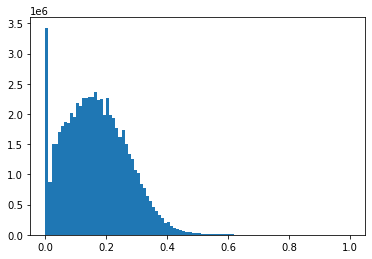

In [11]:
# histogram of similarities
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(similarity_df.similarity, 100);